<a href="https://colab.research.google.com/github/radu-filipescu/Licenta_Google_Colab/blob/main/Copy_of_licenta_reloaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-spiking

Proiectele inițiale:
https://github.com/SaralTayal123/ChromeDinoAI
https://github.com/frhtas/AI-Dino

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import warnings

from keras.optimizers import Adam

import tensorflow as tf
import keras_spiking

import pandas as pd

warnings.filterwarnings("ignore")

In [ ]:
!unzip /content/drive/MyDrive/Licenta-reloaded/images-big.zip -d /content/

In [ ]:
width = 80  # Width of all images
height = 75  # Height of all images


# A function for get images and their labels by given image paths
def get_images_and_labels(images):
    X = []  # A list for store the images
    Y = []  # A list for store the labels

    for img_path in images:
        filename = os.path.basename(img_path)  # Get filename from img_path
        label = filename.split("_")[0]  # Get label from filename
        grey_image = Image.open(img_path).convert("L")  # Convert RGB image to grey_scale image
        img = np.array(grey_image.resize((width, height)))  # Resize the grey image and convert it to numpy array
        img = img / 255  # Normalize the image array
        X.append(img)  # Append image array to X
        Y.append(label)  # Append label to Y

    X = np.array(X)  # Convert list X to numpy array
    X = X.reshape(X.shape[0], width, height, 1)  # Reshape the X

    return X, Y


# A function for convert labels to onehot labels for training
def onehot_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_labels = onehot_encoder.fit_transform(integer_encoded)
    return onehot_labels

In [ ]:
# check if device is ok
tf.test.is_gpu_available(cuda_only=True)

In [ ]:
def get_dense_model():
    model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(80, 75, 1)),
        tf.keras.layers.Dense(10000, activation="relu"),
        tf.keras.layers.Dense(1000, activation="relu"),
        tf.keras.layers.Dense(600, activation="relu"),
        tf.keras.layers.Dense(3, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [ ]:
dt_value = 0.1

def get_spike_dense_model():
    spiking_model = tf.keras.Sequential(
    [
        tf.keras.layers.TimeDistributed(Flatten(input_shape=(width, height, 1))),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10000)),
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
         tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1000)),
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(600)),
        keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(3, activation="softmax"),
    ])

    spiking_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return spiking_model

In [ ]:
def get_timedistributed_CNN_model():
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(width, height, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())


    time_model = Sequential()
    time_model.add(tf.keras.layers.TimeDistributed(model))
    time_model.add(tf.keras.layers.GlobalAveragePooling1D())
    time_model.add(Dense(128, activation="relu"))
    time_model.add(Dropout(0.5))  # For regularization
    time_model.add(Dense(3, activation="softmax"))

    time_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return time_model

In [ ]:
# A function for create a CNN model and return it
def get_CNN_model():
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(width, height, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))  # For regularization
    model.add(Dense(3, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [ ]:
dt_value = 0.1

def get_spike_CNN_model():
    time_model = Sequential()

    time_model.add(tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=(3, 3), input_shape=(width, height, 1))))
    time_model.add(keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value))
    time_model.add(tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    time_model.add(tf.keras.layers.TimeDistributed(Conv2D(32, kernel_size=(3, 3))))
    time_model.add(keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value))
    time_model.add(tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    time_model.add(tf.keras.layers.TimeDistributed(Conv2D(64, kernel_size=(3, 3))))
    time_model.add(keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value))
    time_model.add(tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    time_model.add(tf.keras.layers.TimeDistributed(Flatten())),
    time_model.add(tf.keras.layers.TimeDistributed(Dense(128)))
    time_model.add(keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value))

    time_model.add(tf.keras.layers.GlobalAveragePooling1D())
    time_model.add(Dense(3, activation="softmax"))

    time_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return time_model

In [ ]:
# ESTIMATING CNN

inp = x = tf.keras.Input((10, 80, 75, 1))
x = tf.keras.layers.TimeDistributed(Conv2D(16, kernel_size=(3, 3), input_shape=(width, height, 1)))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = tf.keras.layers.TimeDistributed(Conv2D(32, kernel_size=(3, 3)))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = tf.keras.layers.TimeDistributed(Conv2D(64, kernel_size=(3, 3)))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = tf.keras.layers.TimeDistributed(Flatten())(x)
x = tf.keras.layers.TimeDistributed(Dense(128))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(3, activation="softmax")(x)

model = tf.keras.Model(inp, x)
model.summary()

# estimate model energy
energy = keras_spiking.ModelEnergy(model, example_data=np.ones((1, 10, 80, 75, 1)))
energy.summary(
    columns=(
        "name",
        "energy cpu",
        "energy gpu",
        "energy loihi",
        "neuron_energy cpu",
        "neuron_energy gpu",
        "neuron_energy loihi"
    ),
    print_warnings=False,
)

In [ ]:
# ESTIMATING DENSE

inp = x = tf.keras.Input((10, 80, 75, 1))
x = tf.keras.layers.TimeDistributed(Flatten(input_shape=(width, height, 1)))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10000))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1000))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(600))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inp, x)
model.summary()

# estimate model energy
energy = keras_spiking.ModelEnergy(model, example_data=np.ones((1, 10, 80, 75, 1)))
energy.summary(
    columns=(
        "name",
        "energy cpu",
        "energy gpu",
        "energy loihi",
        "neuron_energy cpu",
        "neuron_energy gpu",
        "neuron_energy loihi"
    ),
    print_warnings=False,
)

In [ ]:
# ESTIMATING CNN2

inp = x = tf.keras.Input((1, 76, 384, 4))
x = tf.keras.layers.TimeDistributed(Conv2D(32, (8,8), input_shape=(76, 384, 4), strides=(2,2)))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))(x)
x = tf.keras.layers.TimeDistributed(Conv2D(64, (4,4), strides=(1,1)))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(7, 7), strides=(3, 3)))(x)
x = tf.keras.layers.TimeDistributed(Conv2D(128, (1, 1), strides=(1,1), activation='relu'))(x)
x = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(3,3), strides=(3,3)))(x)
x = tf.keras.layers.TimeDistributed(Flatten())(x)
x = tf.keras.layers.TimeDistributed(Dense(384))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(Dense(64, name="layer1"))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.TimeDistributed(Dense(8, name="layer2"))(x)
x = keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(3, activation="linear", name="layer3")(x)

model = tf.keras.Model(inp, x)
model.summary()

# estimate model energy
energy = keras_spiking.ModelEnergy(model, example_data=np.ones((1, 1, 76, 384, 4)))
energy.summary(
    columns=(
        "name",
        "energy cpu",
        "energy gpu",
        "energy loihi",
        "neuron_energy cpu",
        "neuron_energy gpu",
        "neuron_energy loihi"
    ),
    print_warnings=False,
)

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 1, 76, 384, 4)]   0         
                                                                 
 time_distributed_208 (TimeD  (None, 1, 35, 189, 32)   8224      
 istributed)                                                     
                                                                 
 spiking_activation_105 (Spi  (None, 1, 35, 189, 32)   0         
 kingActivation)                                                 
                                                                 
 time_distributed_209 (TimeD  (None, 1, 16, 93, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_210 (TimeD  (None, 1, 13, 90, 64)    32832     
 istributed)                                              

In [ ]:
dt_value = 1

def get_RL_model():
    model = Sequential([
            tf.keras.layers.TimeDistributed(Conv2D(32, (8,8), input_shape=(76, 384, 4), strides=(2,2))),
            keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
            tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(5,5), strides=(2, 2))),
            tf.keras.layers.TimeDistributed(Conv2D(64, (4,4), strides=(1,1))),
            keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
            tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(7, 7), strides=(3, 3))),
            tf.keras.layers.TimeDistributed(Conv2D(128, (1, 1), strides=(1,1), activation='relu')),
            tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(3,3), strides=(3,3))),
            tf.keras.layers.TimeDistributed(Flatten()),
            tf.keras.layers.TimeDistributed(Dense(384)),
            keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
            tf.keras.layers.TimeDistributed(Dense(64, name="layer1")),
            keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
            tf.keras.layers.TimeDistributed(Dense(8, name="layer2")),
            keras_spiking.SpikingActivation("relu", spiking_aware_training=True, dt=dt_value),
            tf.keras.layers.GlobalAveragePooling1D(),
            Dense(3, activation="linear", name="layer3"),
        ])

    #pick your learning rate here
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))

    return model

In [ ]:
# Plot number of data categorical
def plot_data():
    # Get unique elements and their counts
    unique_elements, counts = np.unique(Y, return_counts=True)

    # Create a bar plot
    plt.bar(unique_elements, counts)

    # Add labels and title
    plt.xlabel('Categorii')
    plt.ylabel('Număr exemple')
    plt.title('Distribuția acțiunilor')

    # Display the plot
    plt.savefig("categorii.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Plot number of the data for train and test set
    train_size = int(len(images) * 0.9)  # %90
    test_size = int(len(images) * 0.1)  # %10
    print('train: ' + str(train_size), ' - test: ' + str(test_size))
    sets = ['Train', 'Test']
    number_of_data = [train_size, test_size]
    plt.bar(sets, number_of_data, color=['orange', "teal"])
    plt.title('Numărul de date pentru setul de antrenare și cel de validare')
    plt.ylabel('Număr')
    plt.savefig("train_test_num.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Plot confusion matrix of trained model
def plot_confusion_matrix():
    y_pred = model.predict(test_X)
    y_pred = np.argmax(y_pred, axis=1)
    test_y_new = np.argmax(test_y, axis=1)

    cm = confusion_matrix(test_y_new, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["down", "right", "up"])

    disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
    plt.title('Confusion Matrix')
    plt.savefig("confu_matrix_cnn.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# Plot accuracy and loss of the model while training
def plot_accuracy_and_loss():
    plt.plot(history.history['accuracy'], linewidth=2)
    plt.title('Train Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.ylim([0.4, 1])
    plt.savefig("train_acc_spike_cnn.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    plt.plot(history.history['loss'], color='orange', linewidth=2)
    plt.title('Train Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 1.25])
    plt.savefig("train_loss_spike_cnn.pdf", format="pdf", bbox_inches="tight")
    plt.show()

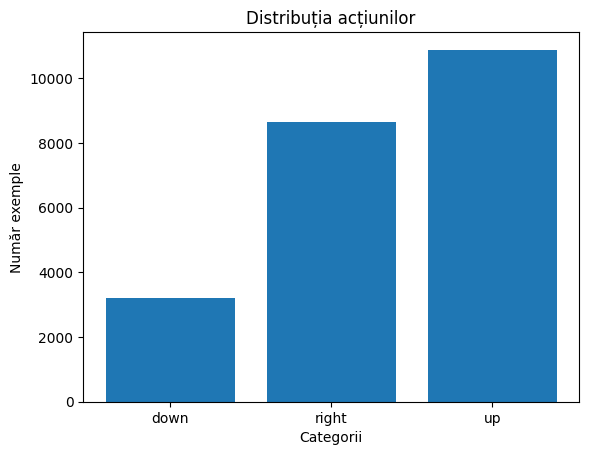

train: 20469  - test: 2274


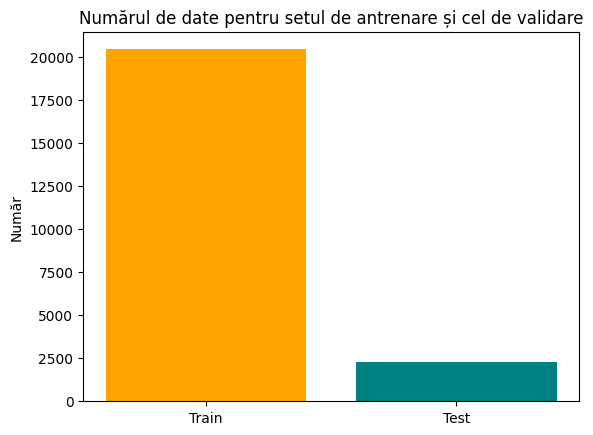

In [ ]:
images = glob.glob("/content/images/*.png")  # Get all image paths with glob

X, Y = get_images_and_labels(images)  # Get images and their labels
plot_data()  # Plot number of data categorical

Y = onehot_labels(Y)  # Convert labels to onehot labels ==> down: 100, right: 010, up: 001

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=10)  # Split the dataset

n_steps = 10

# this is for spike networks (creating temporal axis)
# train_X = tf.tile(train_X[:, None], [1, n_steps, 1, 1, 1])
# test_X = tf.tile(test_X[:, None], [1, n_steps, 1, 1, 1])

In [ ]:
# model = get_dense_model()
model = get_CNN_model()
# model = get_spike_dense_model()
# model = get_spike_CNN_model()

# model = get_RL_model()

In [ ]:
history = model.fit(train_X, train_y, epochs=10, batch_size=32)

Epoch 1/10
640/640 [==============================] - 4s 4ms/step - loss: 0.3417 - accuracy: 0.8881
Epoch 2/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2713 - accuracy: 0.9129
Epoch 3/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2605 - accuracy: 0.9167
Epoch 4/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2494 - accuracy: 0.9207
Epoch 5/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2409 - accuracy: 0.9227
Epoch 6/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2399 - accuracy: 0.9248
Epoch 7/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2337 - accuracy: 0.9261
Epoch 8/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2303 - accuracy: 0.9262
Epoch 9/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2295 - accuracy: 0.9270
Epoch 10/10
640/640 [==============================] - 3s 4ms/step - loss: 0.2222 - accuracy: 0.9288

In [ ]:
model.build((None, 1, 76, 384, 4))
print(model.summary())  # Print model summary

for layer in model.layers:
    print(layer.name, layer.input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 35, 189, 32)   8224      
 ibuted)                                                         
                                                                 
 spiking_activation (Spiking  (None, 1, 35, 189, 32)   0         
 Activation)                                                     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 16, 93, 32)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 13, 90, 64)    32832     
 tributed)                                                       
                                                                 
 spiking_activation_1 (Spiki  (None, 1, 13, 90, 64)    0

In [ ]:
open("/content/drive/MyDrive/Licenta-reloaded/model.json", "w").write(model.to_json())
model.save_weights("/content/drive/MyDrive/Licenta-reloaded/weights.h5")

In [ ]:
# train_accuracy = model.evaluate(train_X, train_y)
# print("Train accuracy: %", train_accuracy[1] * 100)

test_accuracy = model.evaluate(test_X, test_y)

print(test_accuracy)
print("Test accuracy: %", test_accuracy[1] * 100)

72/72 [==============================] - 2s 12ms/step - loss: 0.2828 - accuracy: 0.9059
[0.2828247547149658, 0.9059340953826904]
Test accuracy: % 90.59340953826904


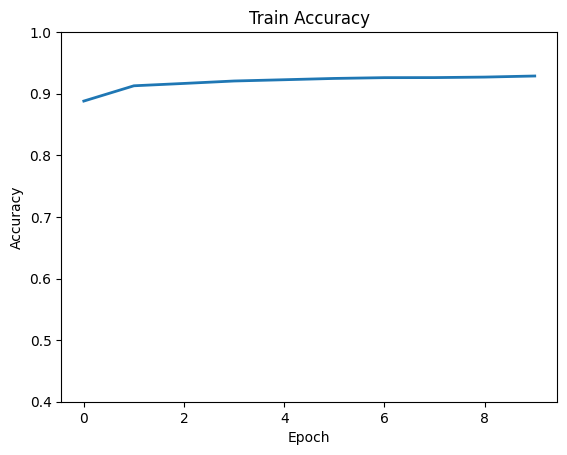

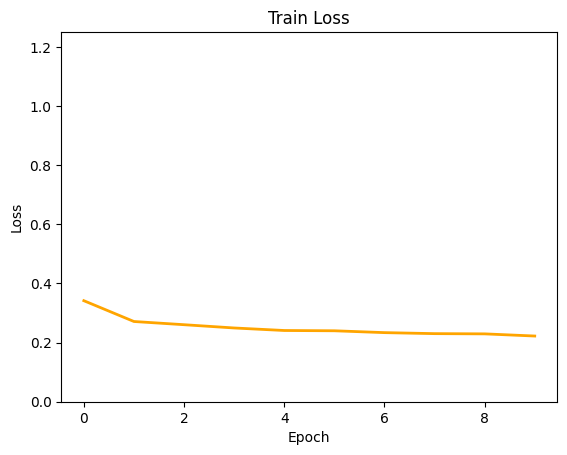

72/72 [==============================] - 0s 2ms/step


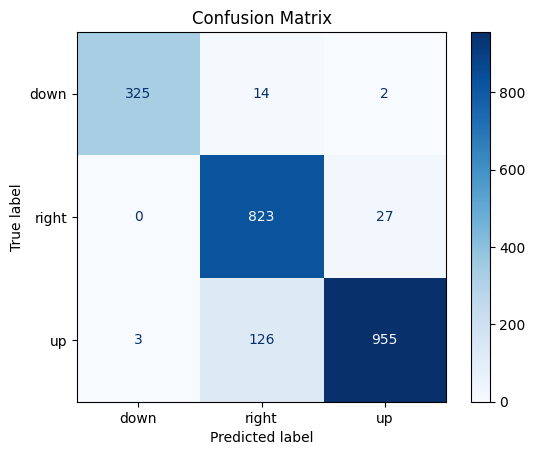

In [ ]:
plot_accuracy_and_loss()  # Plot accuracy and loss of the model while training
plot_confusion_matrix()  # Plot confusion matrix of trained model

In [ ]:
def check_output(seq_model, modify_dt=None):
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model with the functional API, so that we can
    # access the output of intermediate layers
    inp = x = tf.keras.Input(batch_shape=seq_model.layers[0].input_shape)
    spike_layer = 0

    has_global_average_pooling = False

    for layer in seq_model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            # remove the pooling so that we can see the model's
            # output over time
            has_global_average_pooling = True
            continue

        if isinstance(layer, (keras_spiking.SpikingActivation, keras_spiking.Lowpass)):
            cfg = layer.get_config()
            # update dt, if specified
            if modify_dt is not None:
                cfg["dt"] = modify_dt
            # always return the full time series so we can visualize it
            cfg["return_sequences"] = True

            layer = type(layer)(**cfg)

        if isinstance(layer, keras_spiking.SpikingActivation):
            # save this layer so we can access it later
            spike_layer = layer

        x = layer(x)

    func_model = tf.keras.Model(inp, [x, spike_layer.output])

    # copy weights to new model
    func_model.set_weights(seq_model.get_weights())

    # run model
    output, spikes = func_model.predict(test_X)

    if has_global_average_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from only the last timestep
        predictions = np.argmax(output[:, -1], axis=-1)


    targets = np.argmax(test_y, axis=1)

    accuracy = np.equal(predictions, targets).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")

    time = test_X.shape[1] * spike_layer.dt
    n_spikes = spikes * spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        f"Spike rate per neuron (Hz): min={np.min(rates):.2f} "
        f"mean={np.mean(rates):.2f} max={np.max(rates):.2f}"
    )


    # plot output
    for ii in range(5):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)

        # title using argmax
        title_list = ["crouch", "none", "jump"]
        plt.title(title_list[np.argmax(test_y[ii])])
        plt.imshow(test_X[ii][0], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Valorile de ieșire ale stratului")
        plt.plot(
            np.arange(test_X.shape[1]) * spike_layer.dt,
            tf.nn.softmax(output[ii]),
        )
        plt.legend(["crouch", "none", "jump"], loc="upper left")
        plt.xlabel("Timp (s)")
        plt.ylabel("Starea neuronului")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

72/72 [==============================] - 1s 11ms/step
Test accuracy: 81.67%
Spike rate per neuron (Hz): min=0.00 mean=1.60 max=540.00


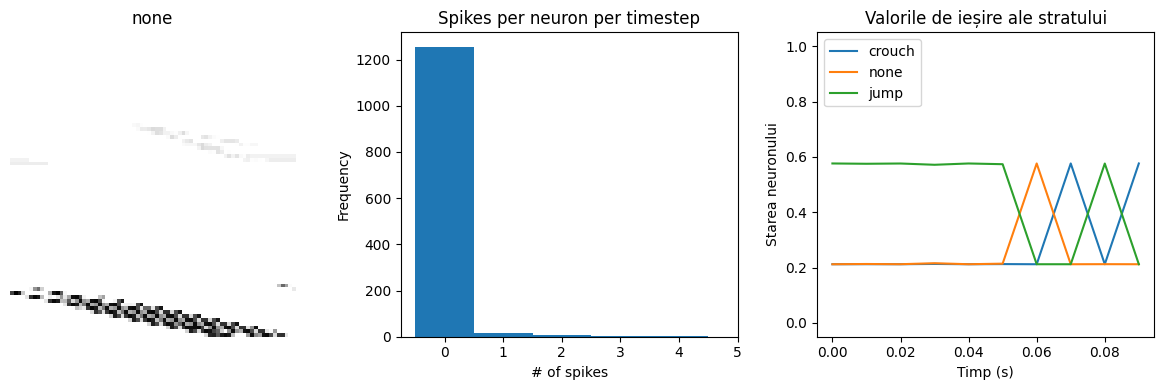

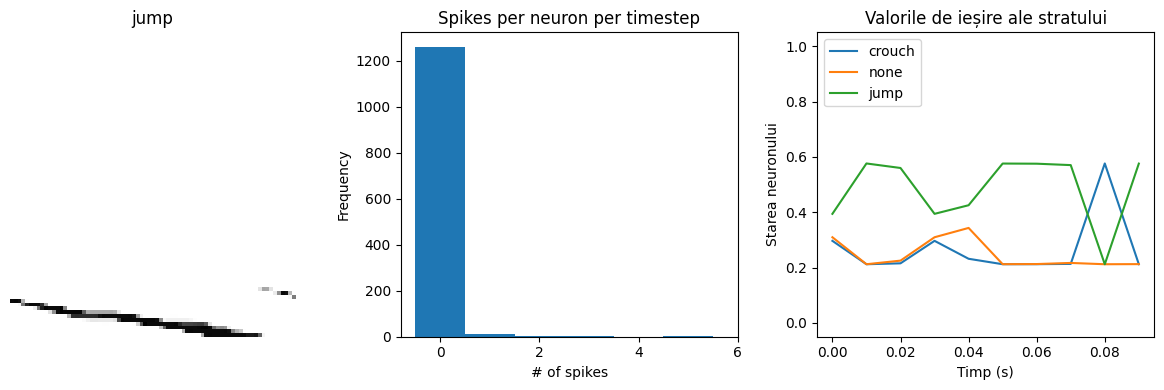

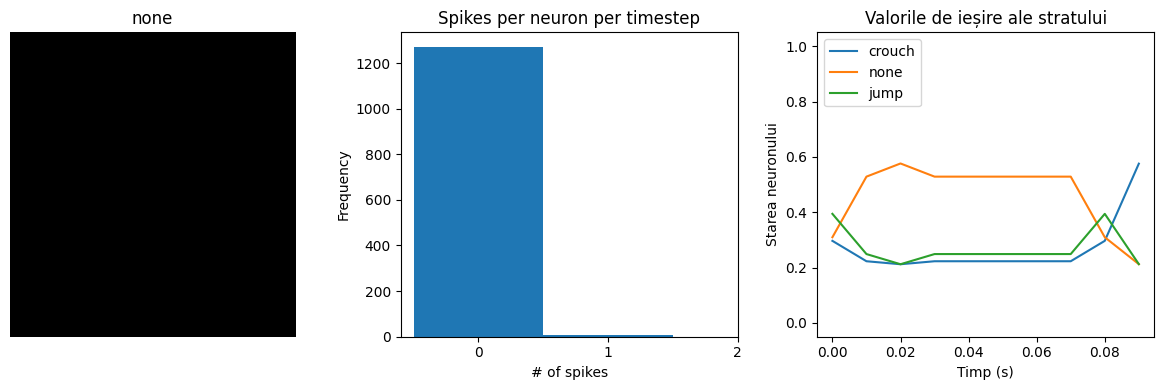

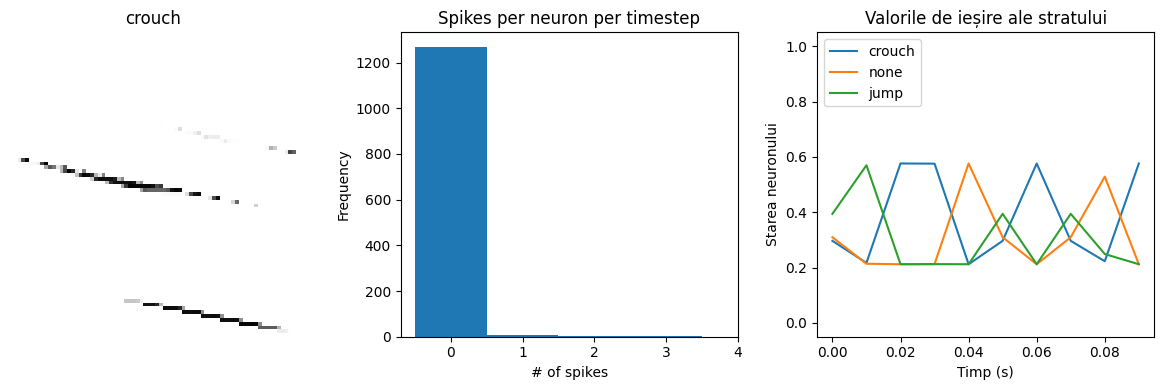

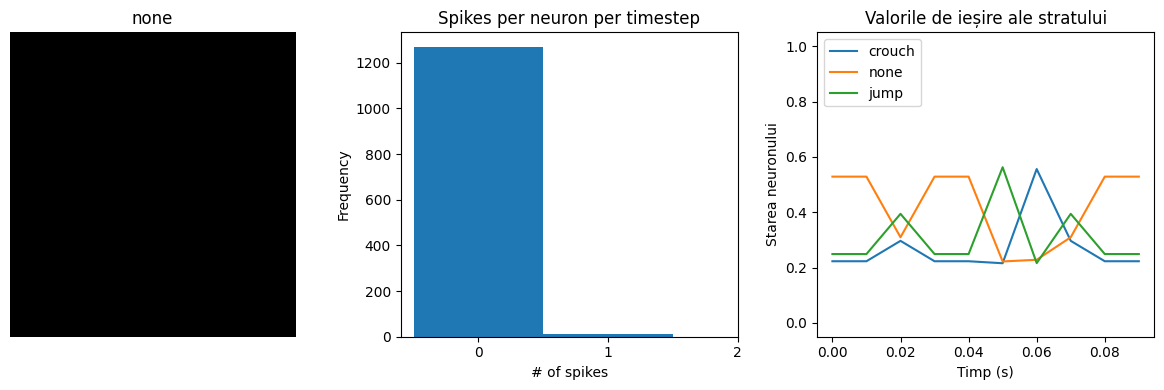

In [ ]:
check_output(model)